 # Paul15 2D Flow Matching



 This notebook trains a Flow Matching model on the Paul15 dataset (2D embedding) and visualizes the denoising process.

In [8]:
import time
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from torch import nn, Tensor
import os

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')


In [9]:
# Set working directory to the script's location to ensure relative paths work correctly
try:
    # For .py scripts
    script_dir = os.path.dirname(os.path.abspath(__file__))
    os.chdir(script_dir)
except NameError:
    # For .ipynb notebooks, __file__ is not defined
    # Use the current working directory or get from ipython
    try:
        from IPython import get_ipython
        ipython = get_ipython()
        if ipython is not None and hasattr(ipython, 'user_ns'):
            # Try to get notebook path if available
            import pathlib
            notebook_path = pathlib.Path().absolute()
            os.chdir(notebook_path)
    except:
        # Fallback: assume we're already in the correct directory
        pass

if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

torch.manual_seed(42)


Using gpu


In [10]:
# Load data; we assume data/paga_paul15.py has already been run to create the data/paul15.h5ad file.
adata = sc.read_h5ad("./data/paul15.h5ad")
print("Loaded data:", adata)

# Extract 2D embedding (ForceAtlas2)
if 'X_draw_graph_fa' in adata.obsm.keys():
    X = adata.obsm['X_draw_graph_fa']
    print("Using X_draw_graph_fa")
elif 'X_umap' in adata.obsm.keys():
    X = adata.obsm['X_umap']
    print("Using X_umap")
else:
    # Fallback to PCA
    X = adata.obsm['X_pca'][:, :2]
    print("Using X_pca (first 2 components)")

# Normalize data
data_mean = X.mean(axis=0)
data_std = X.std(axis=0)
X_norm = (X - data_mean) / data_std

# Convert to torch tensor
dataset = torch.from_numpy(X_norm).float().to(device)

# Get labels for coloring
if 'louvain_anno' in adata.obs:
    cell_types = adata.obs['louvain_anno'].values
else:
    cell_types = adata.obs['louvain'].values

# Pseudotime
if 'dpt_pseudotime' in adata.obs:
    pseudotime = adata.obs['dpt_pseudotime'].values
else:
    pseudotime = np.zeros(len(dataset))


Loaded data: AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all', 'louvain', 'louvain_anno', 'dpt_pseudotime'
    var: 'n_counts', 'mean', 'std'
    uns: 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_anno_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Using X_draw_graph_fa


In [11]:
# Model definitions

class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    
    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)


In [12]:
# Training arguments
lr = 0.001
batch_size = 1024 
iterations = 10000
print_every = 1000
hidden_dim = 128 

# velocity field model init
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr) 

# train
print("Starting training...")
start_time = time.time()
for i in range(iterations):
    optim.zero_grad() 

    # sample data
    idx = torch.randint(0, len(dataset), (batch_size,))
    x_1 = dataset[idx]
    x_0 = torch.randn_like(x_1).to(device)

    # sample time
    t = torch.rand(x_1.shape[0]).to(device) 

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow( vf(path_sample.x_t, path_sample.t) - path_sample.dx_t, 2).mean() 

    # optimizer step
    loss.backward() 
    optim.step() 
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
              .format(i+1, elapsed*1000/print_every, loss.item())) 
        start_time = time.time()


Starting training...
| iter   1000 |  1.74 ms/step | loss    1.547 
| iter   2000 |  2.33 ms/step | loss    1.396 
| iter   3000 |  1.35 ms/step | loss    1.476 
| iter   4000 |  1.34 ms/step | loss    1.436 
| iter   5000 |  1.40 ms/step | loss    1.443 
| iter   6000 |  1.33 ms/step | loss    1.489 
| iter   7000 |  1.33 ms/step | loss    1.365 
| iter   8000 |  1.33 ms/step | loss    1.378 
| iter   9000 |  1.33 ms/step | loss    1.453 
| iter  10000 |  1.33 ms/step | loss    1.409 


In [13]:
# Sampling
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t, **extras)

wrapped_vf = WrappedModel(vf)

# Generate samples
num_samples = 2000
step_size = 0.05
T = torch.linspace(0, 1, 10).to(device)

x_init = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)

sol = sol.cpu().numpy()
T_cpu = T.cpu().numpy()

# Reverse normalization
sol_orig = sol * data_std + data_mean


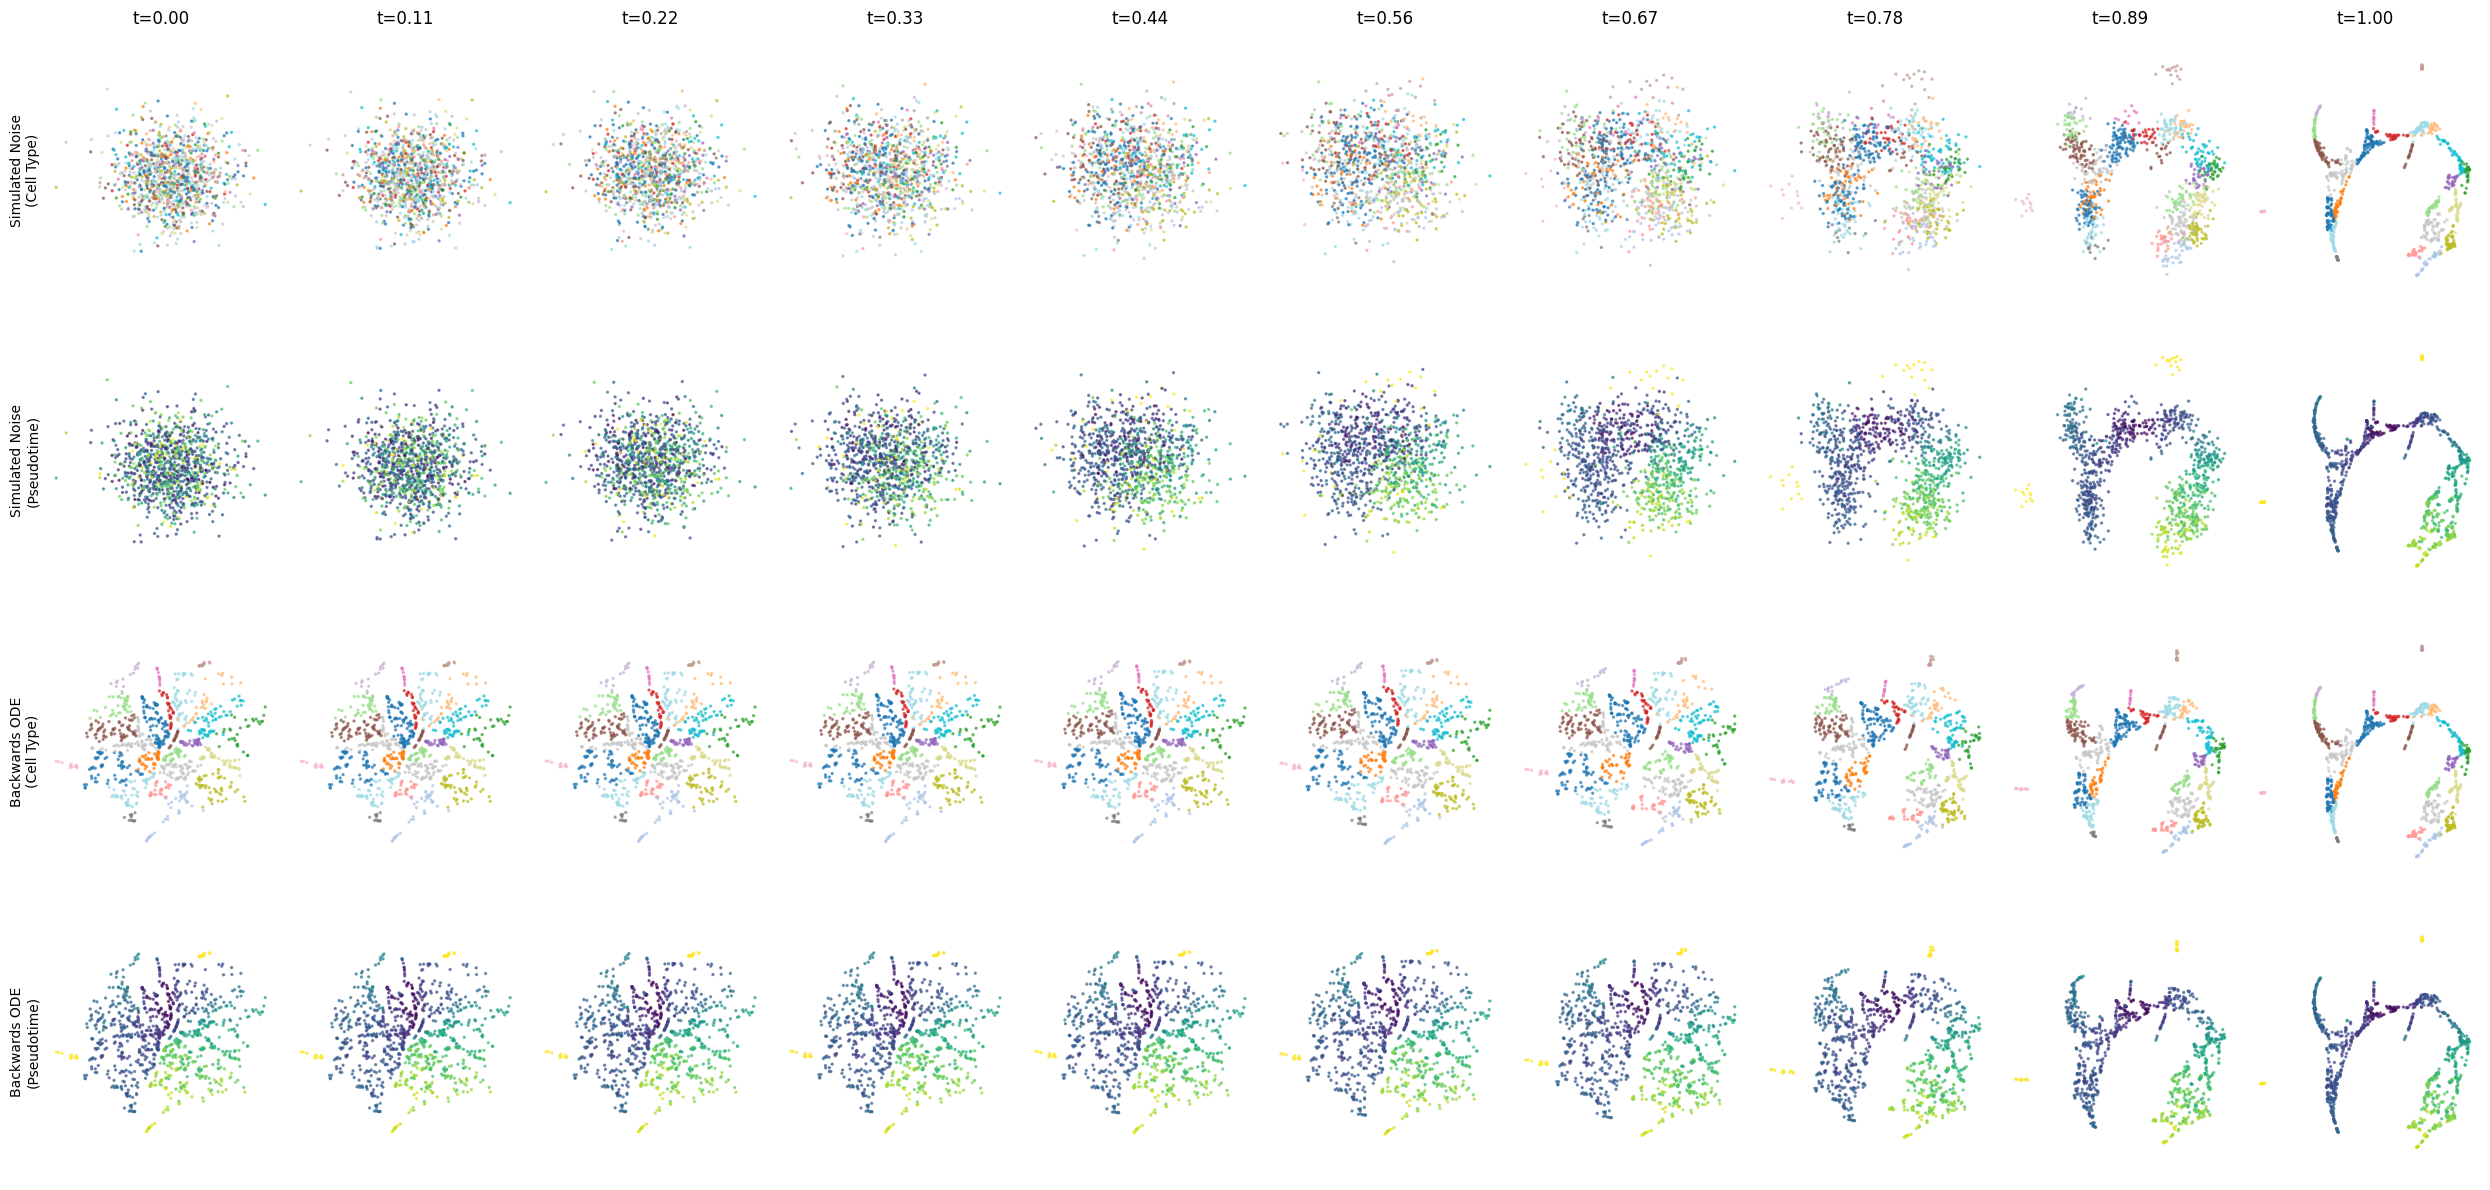

Saved visualization to ./results/paul15_flow_matching_2d.png


In [14]:
# Visualization
fig, axs = plt.subplots(4, 10, figsize=(25, 12))

# Prepare colors
unique_types = np.unique(cell_types)
type_to_int = {t: i for i, t in enumerate(unique_types)}
c_types = [type_to_int[t] for t in cell_types]

c_dpt = np.nan_to_num(pseudotime)

vis_idx = np.random.choice(len(dataset), size=1000, replace=False)
x_data_vis = dataset[vis_idx]
c_type_vis = np.array([type_to_int[cell_types[i]] for i in vis_idx])
c_dpt_vis = pseudotime[vis_idx]
# Replace inf/nan with max valid pseudotime
valid_mask = np.isfinite(c_dpt_vis)
if valid_mask.any():
    max_valid = c_dpt_vis[valid_mask].max()
    c_dpt_vis = np.where(valid_mask, c_dpt_vis, max_valid)

# A. Simulated Linear Path (Data <-> Noise)
x_data_vis_gpu = x_data_vis.to(device) 
x_target_noise = torch.randn_like(x_data_vis_gpu)
velocity = x_target_noise - x_data_vis_gpu

sim_path_list = []
T_reversed = torch.flip(T, dims=[0])

for t_val in T_reversed:
    xt = x_data_vis_gpu + t_val * velocity
    sim_path_list.append(xt.clone())

sol_sim = torch.stack(sim_path_list).cpu().numpy()
sol_sim_orig = sol_sim * data_std + data_mean

# B. Model-Based Reconstruction (Data -> Noise -> Data)
T_backward = torch.linspace(1, 0, 10).to(device)
sol_backward = solver.sample(time_grid=T_backward, x_init=x_data_vis_gpu, method='midpoint', step_size=step_size, return_intermediates=True)

sol_model = torch.flip(sol_backward, dims=[0]).cpu().numpy()
sol_model_orig = sol_model * data_std + data_mean

# Plotting
for i in range(10):
    # Row 1: Simulated Noise Process (Cell Type)
    axs[0, i].scatter(sol_sim_orig[i, :, 0], sol_sim_orig[i, :, 1], c=c_type_vis, s=2, alpha=0.6, cmap='tab20')
    axs[0, i].set_title(f't={T_cpu[i]:.2f}') 
    axs[0, i].axis('equal')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[0, i].spines['left'].set_visible(False)
    axs[0, i].spines['right'].set_visible(False)
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['bottom'].set_visible(False)

    # Row 2: Simulated Noise Process (Pseudotime)
    axs[1, i].scatter(sol_sim_orig[i, :, 0], sol_sim_orig[i, :, 1], c=c_dpt_vis, s=2, alpha=0.6, cmap='viridis')
    axs[1, i].axis('equal')
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].spines['left'].set_visible(False)
    axs[1, i].spines['right'].set_visible(False)
    axs[1, i].spines['top'].set_visible(False)
    axs[1, i].spines['bottom'].set_visible(False)
    
    # Row 3: Backwards ODE (Cell Type)
    axs[2, i].scatter(sol_model_orig[i, :, 0], sol_model_orig[i, :, 1], c=c_type_vis, s=2, alpha=0.6, cmap='tab20')
    axs[2, i].axis('equal')
    axs[2, i].set_xticks([])
    axs[2, i].set_yticks([])
    axs[2, i].spines['left'].set_visible(False)
    axs[2, i].spines['right'].set_visible(False)
    axs[2, i].spines['top'].set_visible(False)
    axs[2, i].spines['bottom'].set_visible(False)

    # Row 4: Backwards ODE (Pseudotime)
    axs[3, i].scatter(sol_model_orig[i, :, 0], sol_model_orig[i, :, 1], c=c_dpt_vis, s=2, alpha=0.6, cmap='viridis')
    axs[3, i].axis('equal')
    axs[3, i].set_xticks([])
    axs[3, i].set_yticks([])
    axs[3, i].spines['left'].set_visible(False)
    axs[3, i].spines['right'].set_visible(False)
    axs[3, i].spines['top'].set_visible(False)
    axs[3, i].spines['bottom'].set_visible(False)

# Show y-axis labels only for leftmost column
axs[0, 0].set_ylabel("Simulated Noise\n(Cell Type)", fontsize=10, visible=True)
axs[1, 0].set_ylabel("Simulated Noise\n(Pseudotime)", fontsize=10, visible=True)
axs[2, 0].set_ylabel("Backwards ODE\n(Cell Type)", fontsize=10, visible=True)
axs[3, 0].set_ylabel("Backwards ODE\n(Pseudotime)", fontsize=10, visible=True)

# Make y-axis labels visible for leftmost column
for row in range(4):
    axs[row, 0].yaxis.set_visible(True)
    axs[row, 0].set_yticks([])
    axs[row, 0].spines['left'].set_visible(False)
    axs[row, 0].spines['right'].set_visible(False)
    axs[row, 0].spines['top'].set_visible(False)
    axs[row, 0].spines['bottom'].set_visible(False)

plt.tight_layout()
output_path = "./results/paul15_flow_matching_2d.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
print(f"Saved visualization to {output_path}")
